In [28]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [3]:
# This implementation is based upon on the research paper 
# Bengio et al. 2003

In [76]:
words = open('src/names.txt').read().splitlines()

In [74]:
chars = list(sorted(set(''.join(words))))

stoi = {ch:i+1 for i, ch in enumerate(chars) }
itos = {i+1:ch for i, ch in enumerate(stoi)}
itos[0] = '.'
vocab_size = len(itos)

stoi['.']=0

In [7]:

block_size = 3
def build_dataset(words) :
    Xs, Ys = [], []
    
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            Xs.append(context)
            Ys.append(stoi[ch])
    
            t =  [itos[i] for i in context]
            
            context = context[1:] + [stoi[ch]]
            
    Xs = torch.tensor(Xs)
    Ys = torch.tensor(Ys)

    return Xs, Ys



In [80]:
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words) )
n2 = int(0.9 * len(words) )

X_tr, Y_tr = build_dataset(words[:n1])
X_val, Y_val = build_dataset(words[n1:n2])
X_test, Y_test =  build_dataset(words[n2:])


In [20]:
n_embd = 10 # dim of char embedding vectors
n_hidden = 200 # num of neurons in hidden layer of MLP 

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size,n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden) , generator=g) * (5/3) /   (n_embd * block_size)**0.5   
b1 = torch.randn(n_hidden,   generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),  generator=g) * 0.01
b2 = torch.randn(vocab_size , generator=g) * 0 

bngain = torch.ones((1,n_hidden)))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
    p.requires_grad = True


In [21]:
lre = torch.linspace(-3,0,1000)
lrs = 10 ** lre
lri = []
lossi = []
steps = []

In [26]:
max_steps = 200000
batch_size = 32

for i in range(max_steps):

    #mini-batch construction
    ixs = torch.randint(0, X_tr.shape[0] , (batch_size,), generator = g)
    Xb, Yb = X_tr[ixs], Y_tr[ixs]

    #forwards pass
    
    emb = C[Xb] # embed chars into vectors
    embcat = emb.view(emb.shape[0], - 1) # concat vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre act
    bnmeani = (hpreact - hpreact.mean(0, keepdim=True) )
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = (bngain * (hpreact - bnmeani) / bnstdi) + bnbias 
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2   # output layer 
    loss = F.cross_entropy(logits, Yb) # loss function

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 + 

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01 # lr-decay
    for p in parameters:
        p.data += - lr * p.grad

    
    if i % 10000 == 0: # print every 10k training iteration
        print(f'{i}/ {max_steps}: {loss.item()}')
    lossi.append(loss.log10().sum())


0/ 200000: 25.743986129760742
10000/ 200000: 2.9340391159057617
20000/ 200000: 2.2072336673736572
30000/ 200000: 2.817751407623291
40000/ 200000: 2.659165620803833
50000/ 200000: 2.532107353210449
60000/ 200000: 2.138410806655884
70000/ 200000: 1.6205224990844727
80000/ 200000: 2.0646181106567383
90000/ 200000: 2.026235818862915
100000/ 200000: 2.2258076667785645
110000/ 200000: 2.018887996673584
120000/ 200000: 2.0285024642944336
130000/ 200000: 2.254905939102173
140000/ 200000: 1.9220720529556274
150000/ 200000: 2.0150492191314697
160000/ 200000: 2.198180675506592
170000/ 200000: 2.1654601097106934
180000/ 200000: 2.1580162048339844
190000/ 200000: 2.0162503719329834


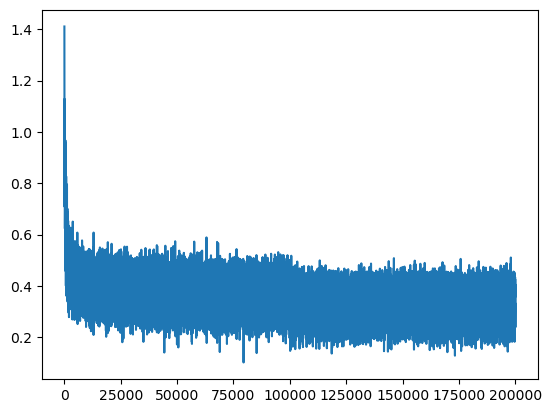

In [55]:
plt.plot([loss.detach().numpy() for loss in lossi])

In [ ]:
with torch.no_grad() :
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim = True)
    bnstd = hpreact.std(0, keepdim = True)

In [53]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (X_tr, Y_tr),
        'val' : (X_val, Y_val),
        'test' : (X_test, Y_test)
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    h = (bngain * ((hpreact - bnmean_running ) / bnstd_running) + bnbias 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.138824462890625
val 2.1741366386413574


In [54]:
g = torch.Generator().manual_seed(2147483647 + 21)

# sampling
 
for _ in range(11):
    out = []
    context =  [0] * block_size

    while True:
        emb = C[torch.tensor([context])]
        h1 = torch.tanh((emb.view(1,-1)) @ W1 + b1 )
        logits = h1 @ W2 + b2
        probs =  F.softmax(logits, 1)
        ix = torch.multinomial(probs,num_samples= 1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))


ker.
de.
aaryn.
risabigiliya.
siel.
inzlee.
atharcoleeshanvian.
laise.
laysloikh.
gan.
arsishmabdulla.


In [160]:
#PYTORCH ADAPTATION

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / (fan_in**0.5)
        self.bias = torch.randn(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim = True)
            xvar = x.var(0, keepdim = True, unbiased = True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [161]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.rand((vocab_size, n_embd), generator = g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47024


In [207]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []
for i in range(max_steps):
        
    ix = torch.randint(0, X_tr.shape[0], (batch_size,) , generator = g)
    Xb, Yb = X_tr[ix], Y_tr[ix]

    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    for layer in layers:
        layer.out.retain_grad()

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01

    for p in parameters:
        p.data += - lr * p.grad

    if i % 10000 == 0:
        print(f'{i} / {max_steps} : {loss.item()}')
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

    
    if i >= 1000 :
        break
        


0 / 200000 : 2.262106418609619


In [154]:
# DIAGNOSTICS

layer 2 (Tanh) : mean +0.01, std 0.65, saturated: 4.59%
layer 5 (Tanh) : mean +0.00, std 0.67, saturated: 3.88%
layer 8 (Tanh) : mean -0.01, std 0.67, saturated: 3.25%
layer 11 (Tanh) : mean -0.00, std 0.67, saturated: 2.91%
layer 14 (Tanh) : mean -0.02, std 0.67, saturated: 2.62%


Text(0.5, 1.0, 'Activation distribution')

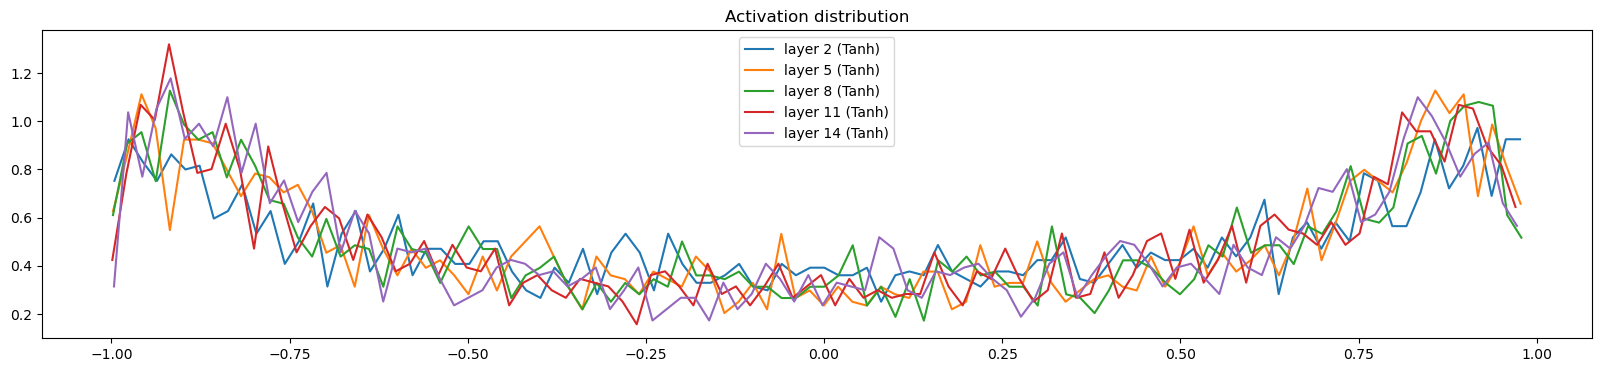

In [190]:
plt.figure(figsize=(20,4))
legends = []

for i , layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%s) : mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean() * 100 ))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Activation distribution')

layer 2 (Tanh) : mean +0.00, std 3.045168e-03
layer 5 (Tanh) : mean -0.00, std 2.800227e-03
layer 8 (Tanh) : mean -0.00, std 2.439595e-03
layer 11 (Tanh) : mean +0.00, std 2.277894e-03
layer 14 (Tanh) : mean -0.00, std 2.194576e-03


Text(0.5, 1.0, 'Gradient Distribution')

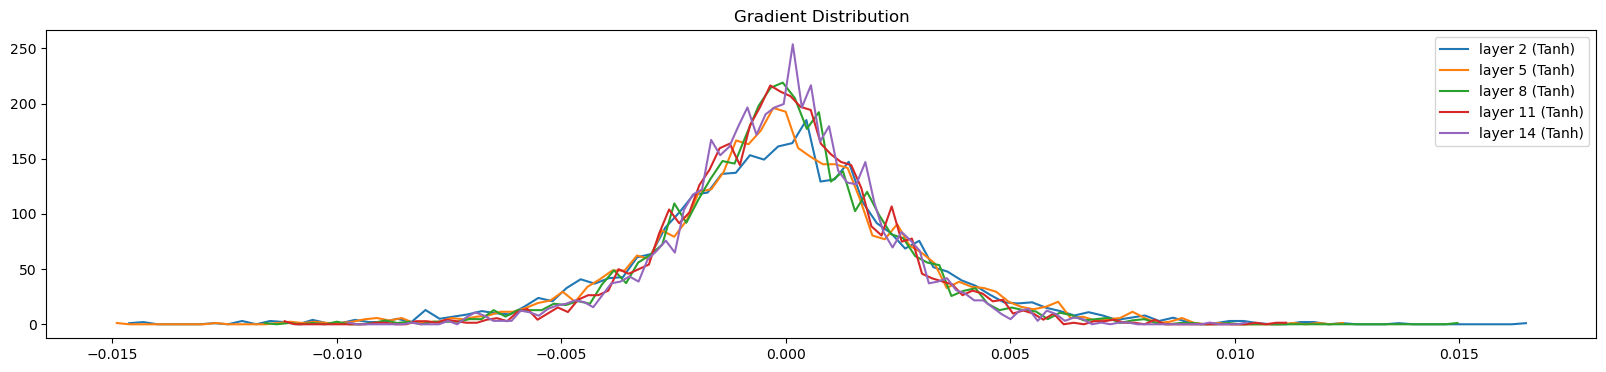

In [178]:
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%s) : mean %+.2f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')

plt.legend(legends)
plt.title('Gradient Distribution')

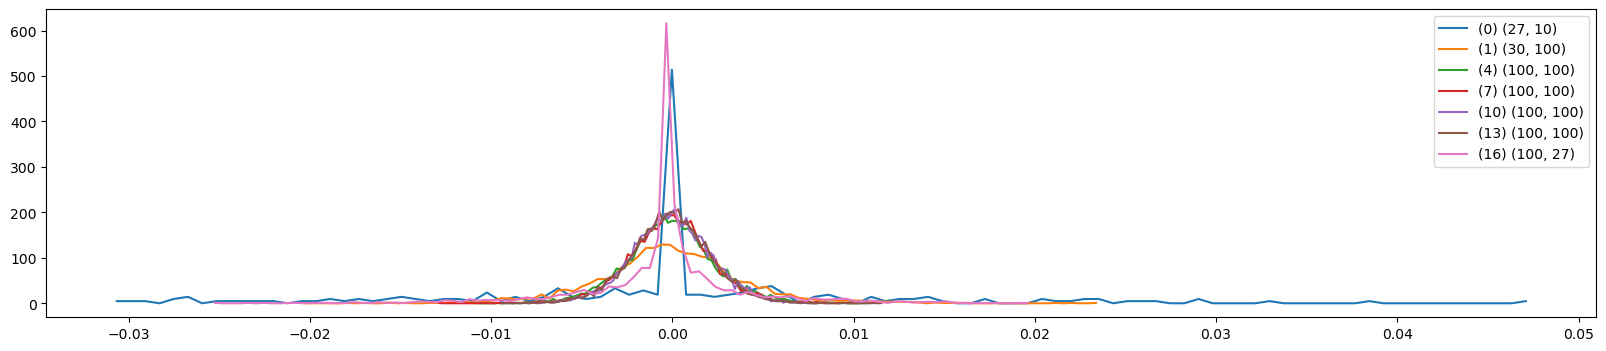

In [191]:
plt.figure(figsize=(20,4))
legends = []

for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2: # plotting weights only
        hy, hx = torch.histogram(t, density = True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'({i}) {tuple(p.shape)}')
plt.legend(legends)


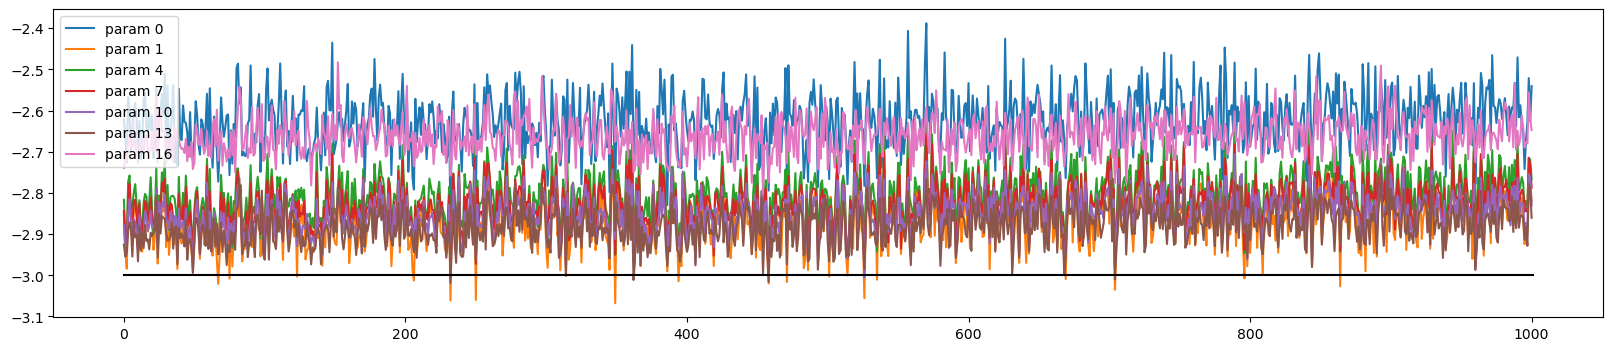

In [208]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends);

In [211]:
@torch.no_grad() 
def split_loss(split):
  x,y = {
    'train': (X_tr, Y_tr),
    'val': (X_val, Y_val),
    'test': (X_test, Y_test),
  }[split]
  emb = C[x] 
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.2259535789489746
val 2.2346749305725098


In [212]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

mora.
kayannieel.
ndheyah.
renyra.
brerlee.
aderedielin.
shi.
jen.
edelisan.
narielleimhonelin.
shubergahiriel.
kin.
renelilanterofius.
kavdi.
kyleni.
eha.
kaysh.
sanyah.
hil.
salynn.
